# **Delhi Air Quality 2019** Time series Analysis 

**Delhi's airquality** has been extremely poor over a couple of months this year in 2019 and this is a repeated pattern which was observed in 2017 and 2018 as well. Many reasons have been attributed to the increase in air pollution and mainly it is driven by Industrial, vehicle, stuble burning. This analysis is to visualise air pollution for the following period (start: 2019-08-18, end: 2019-11-14) and forecast **PM 2.5** a month forward using a simple SARIMA and SARIMAX model.

**Data source:** It was difficult to find this data. However, I have sourced it from https://openaq.org/, the recording station is IGI Terminal 3 in Delhi.

In [ ]:
#importing all required libraries
import numpy as np
import pandas as pd
import statsmodels.api as sm
import matplotlib.pyplot as plt

In [82]:
#read the csv
data = pd.read_csv('openaq.csv')
data.head(3)


,location,city,country,utc,local,parameter,value,unit,latitude,longitude,attribution
0,"IGI Airport (T3), Delhi - IMD",Delhi,IN,2019-11-14T17:30:00.000Z,2019-11-14T23:00:00+05:30,no2,60.89,µg/m³,28.562776,77.118005,"[{""name"":""Central Pollution Control Board"",""ur..."
1,"IGI Airport (T3), Delhi - IMD",Delhi,IN,2019-11-14T17:30:00.000Z,2019-11-14T23:00:00+05:30,o3,10.00,µg/m³,28.562776,77.118005,"[{""name"":""Central Pollution Control Board"",""ur..."
2,"IGI Airport (T3), Delhi - IMD",Delhi,IN,2019-11-14T17:30:00.000Z,2019-11-14T23:00:00+05:30,pm25,315.76,µg/m³,28.562776,77.118005,"[{""name"":""Central Pollution Control Board"",""ur..."


In [83]:
data.info(verbose = True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14585 entries, 0 to 14584
Data columns (total 11 columns):
location       14585 non-null object
city           14585 non-null object
country        14585 non-null object
utc            14585 non-null object
local          14585 non-null object
parameter      14585 non-null object
value          14585 non-null float64
unit           14585 non-null object
latitude       14585 non-null float64
longitude      14585 non-null float64
attribution    14585 non-null object
dtypes: float64(3), object(8)
memory usage: 1.2+ MB


In [ ]:
# we need to extract date from the local datetime string with time zone
data['date'] = data['local'].str[:10]
data = data.iloc[:,[0,5,6,11]]
data['date'] = pd.to_datetime(data['date'])

In [85]:
#printing the date range of the dateset
print('min: ',min(data['date']))
print('max: ',max(data['date']))

min:  2019-08-18 00:00:00
max:  2019-11-14 00:00:00


In [86]:
data.head()

,location,parameter,value,date
0,"IGI Airport (T3), Delhi - IMD",no2,60.89,2019-11-14
1,"IGI Airport (T3), Delhi - IMD",o3,10.00,2019-11-14
2,"IGI Airport (T3), Delhi - IMD",pm25,315.76,2019-11-14
3,"IGI Airport (T3), Delhi - IMD",pm10,491.99,2019-11-14
4,"IGI Airport (T3), Delhi - IMD",co,3800.00,2019-11-14


In [ ]:
#creating a wide dataset
delhi_aqi = pd.pivot_table(data,values='value',index=['date'],columns='parameter')

In [88]:
delhi_aqi.head(3)

parameter,co,no2,o3,pm10,pm25
date,,,,,
2019-08-18,0.000000,16.411176,7.389020,60.913137,23.720588
2019-08-19,0.000000,68.390937,7.417500,85.530937,12.618125
2019-09-07,847.297297,39.665405,20.679189,73.730270,27.408378


### Visual Inspection
From the below plots of the data we observe that pollution levels of O3 is very random, while others show some pattern to the data. Since we are predicting PM25 i.e. pm 2.5 we observse that as pm10 increases so does pm25. 

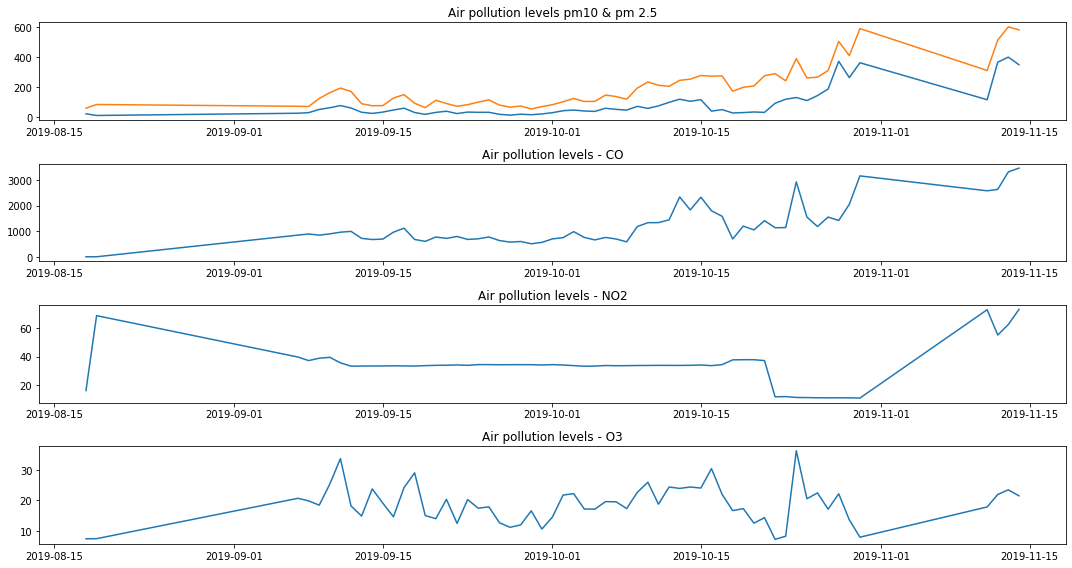

In [106]:
#visual inspection of time series
fig , (ax1,ax2,ax3,ax4) = plt.subplots(4,1,figsize = (15,8))
ax1.plot(delhi_aqi.index,delhi_aqi['pm25'],delhi_aqi.index,delhi_aqi['pm10'])
ax1.set_title('Air pollution levels pm10 & pm 2.5')
ax2.plot(delhi_aqi.index,delhi_aqi['co'])
ax2.set_title('Air pollution levels - CO')
ax3.plot(delhi_aqi.index,delhi_aqi['no2'])
ax3.set_title('Air pollution levels - NO2')
ax4.plot(delhi_aqi.index,delhi_aqi['o3'])
ax4.set_title('Air pollution levels - O3')
fig.tight_layout()
plt.show()

In this boxplot, we see that NO2 levels havent been very sporadic, however, there is a lot of high deviation on few occassions. i.e. outliers are present. Our Target variables **pm25** has also seen some outliers and this is evident fromt the above line charts. 

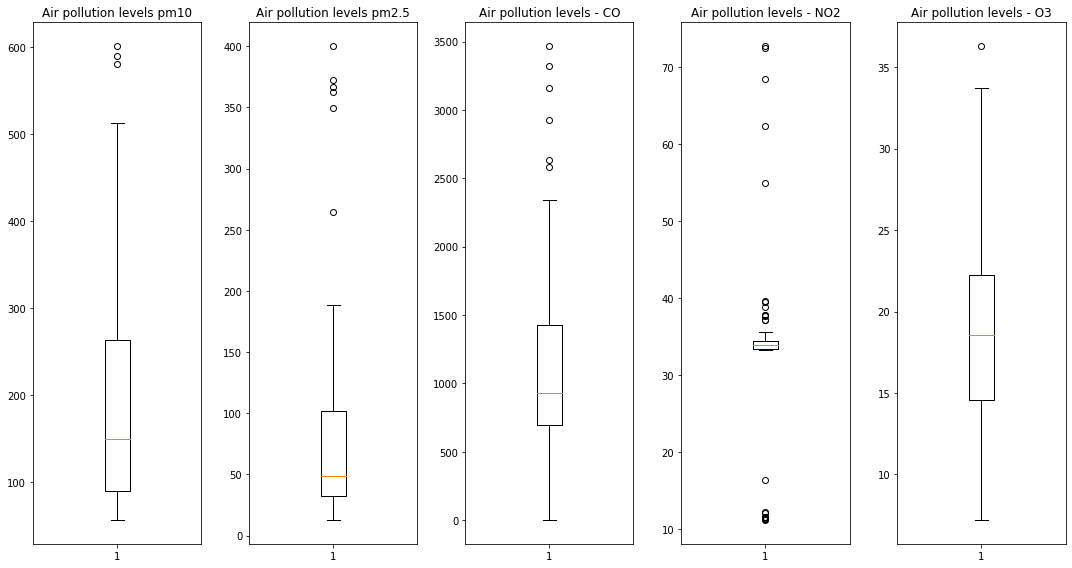

In [113]:
fig , (ax1,ax2,ax3,ax4,ax5) = plt.subplots(1,5,figsize = (15,8))
ax1.boxplot(delhi_aqi['pm10'])
ax1.set_title('Air pollution levels pm10')
ax2.boxplot(delhi_aqi['pm25'])
ax2.set_title('Air pollution levels pm2.5')
ax3.boxplot(delhi_aqi['co'])
ax3.set_title('Air pollution levels - CO')
ax4.boxplot(delhi_aqi['no2'])
ax4.set_title('Air pollution levels - NO2')
ax5.boxplot(delhi_aqi['o3'])
ax5.set_title('Air pollution levels - O3')
fig.tight_layout()
plt.show()

### Models

We will build a 2  time series models, one with regressors, while one without and then forecast a month forward. We need to pay caution as this is a very small dataset and It is just to see if we should see an increse in PM 2.5 

In [128]:
#checking for staionarity, it looks like we need to difference the series once to achieve stationarity 
print('adfuller stationarity test p-value:',sm.tsa.stattools.adfuller(delhi_aqi['pm25'])[1])
print('adfuller stationarity test p-value:',sm.tsa.stattools.adfuller(delhi_aqi['pm25'].diff(1)[1:])[1])


adfuller stationarity test p-value: 0.8816756214506627
adfuller stationarity test p-value: 0.026977575594891764


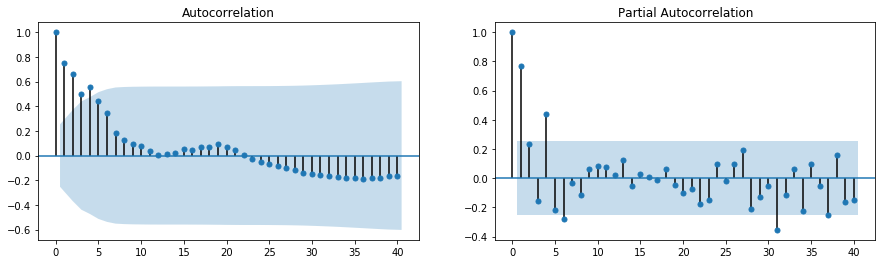

In [123]:
fig, axes = plt.subplots(1, 2, figsize=(15,4))
fig = sm.graphics.tsa.plot_acf(delhi_aqi['pm25'], lags=40, ax=axes[0])
fig = sm.graphics.tsa.plot_pacf(delhi_aqi['pm25'], lags=40, ax=axes[1])
plt.show()

#### MODEL1 with Regressors (variable `O3` was removed as it had a high pvalue and didnt contribute to the model)

In [239]:
exog_ = delhi_aqi.iloc[:,[0,1,3]]
mod1 = sm.tsa.statespace.SARIMAX(delhi_aqi['pm25'], trend='c', order=(0,1,0),exog = exog_)
res1 = mod1.fit(disp=False)
preds1 = res1.predict()
print(res1.summary())

                           Statespace Model Results                           
Dep. Variable:                   pm25   No. Observations:                   60
Model:               SARIMAX(0, 1, 0)   Log Likelihood                -272.433
Date:                Sat, 16 Nov 2019   AIC                            554.865
Time:                        12:05:23   BIC                            565.253
Sample:                             0   HQIC                           558.920
                                 - 60                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      2.3773      3.824      0.622      0.534      -5.117       9.872
co            -0.0429      0.008     -5.394      0.000      -0.058      -0.027
no2           -1.1792      0.316     -3.732      0.0

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


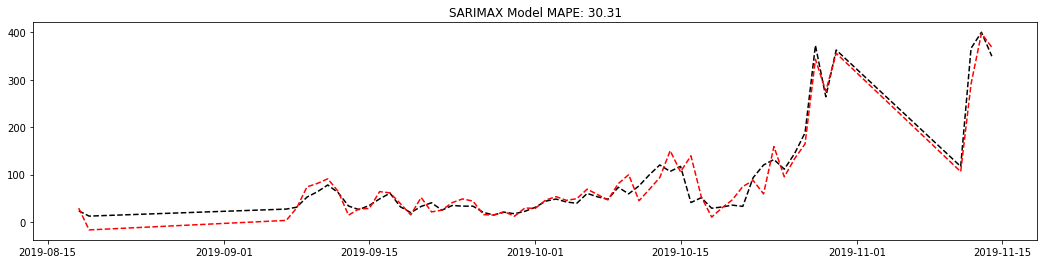

In [240]:
def mape(actual,preds):
  return np.mean(np.abs((actual - preds) / actual)) * 100


plt.figure(figsize = (18,4))
plt.plot(delhi_aqi['pm25'],'--k')
plt.plot(preds1,'--r')
plt.title('SARIMAX Model MAPE: '+str(round(mape(delhi_aqi['pm25'],preds1),2)))
plt.show()

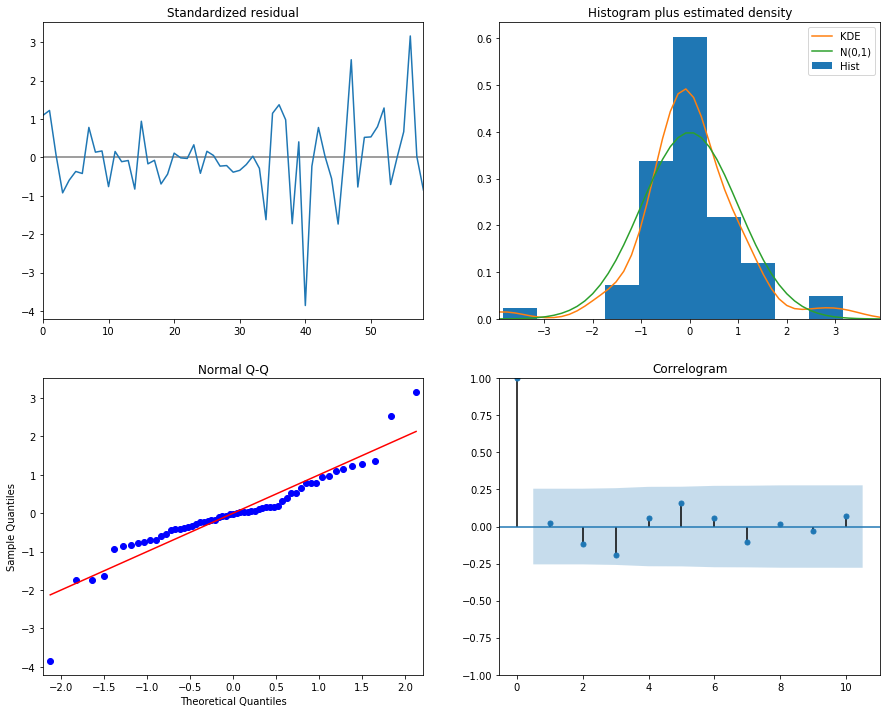

In [214]:
_ = res1.plot_diagnostics(figsize=(15, 12))

#### MODEL2 (univariate time series and forecast)

In [195]:
mod2 = sm.tsa.statespace.SARIMAX(delhi_aqi['pm25'], trend='c', order=(1,1,3))
res2 = mod2.fit(disp=False)
preds2 = res2.predict()
print(res2.summary())

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


                           Statespace Model Results                           
Dep. Variable:                   pm25   No. Observations:                   60
Model:               SARIMAX(1, 1, 3)   Log Likelihood                -312.405
Date:                Sat, 16 Nov 2019   AIC                            636.810
Time:                        11:34:28   BIC                            649.275
Sample:                             0   HQIC                           641.676
                                 - 60                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      6.5581      7.625      0.860      0.390      -8.387      21.503
ar.L1         -0.3355      0.153     -2.193      0.028      -0.635      -0.036
ma.L1         -0.0721      0.242     -0.298      0.7

In [236]:
print(max(preds2.index))
dt_range = pd.date_range(pd.to_datetime('2019-11-15'), periods=30).tolist()
dt_range = pd.Series(dt_range)
forecast_ = pd.Series(list(res2.forecast(steps=30)))

forecast_ = pd.concat([dt_range,forecast_],axis = 1)
forecast_.columns = ['date','forecast']
forecast_.set_index('date',inplace = True)

2019-11-14 00:00:00


/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:576: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)


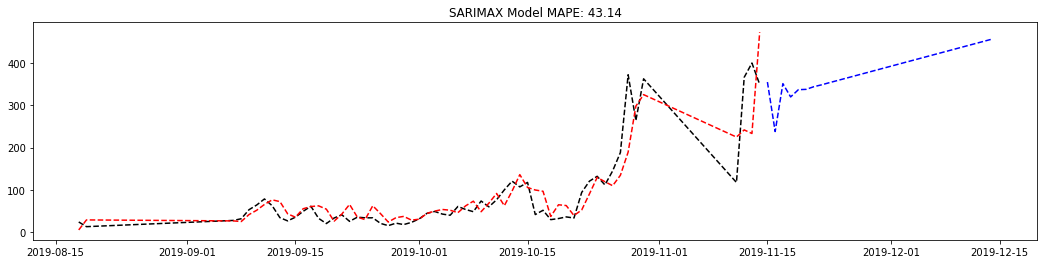

In [237]:
plt.figure(figsize = (18,4))
plt.plot(delhi_aqi['pm25'],'--k')
plt.plot(preds2,'--r')
plt.plot(forecast_,'--b')
plt.title('SARIMAX Model MAPE: '+str(round(mape(delhi_aqi['pm25'],preds2),2)))
plt.show()

We find that the model forecasts that in next 30 days we should expect the pollution of `pm 2.5 to rise higher`. Only If we had more data and preferably from the last 2 years we could have been more confident of this forecast.

We also saw that the MAPE of `model1` **with regressors** is around `~30%` which is way better than our **univariate model** i.e. `model2`, which gives us a MAPE of `~43%` 